# 1. MNIST

In [1]:
import os.path

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', cache=True, data_home='./datasets')

mnist

/Users/wttch/workspace/PG/ENV/AI@3.11/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 
      

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
import numpy as np
import pandas as pd

X, y = mnist['data'], mnist['target'] # type: pd.DataFrame, pd.Series

X.shape, y.shape

((70000, 784), (70000,))

(-0.5, 27.5, 27.5, -0.5)

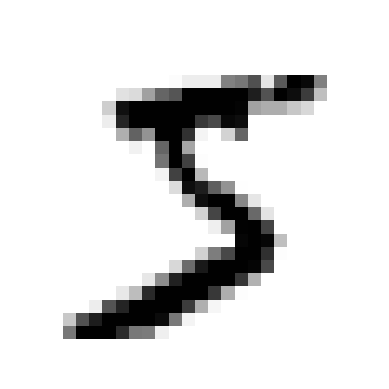

In [4]:
import matplotlib.pyplot as plt

some_digit = X.iloc[0] # type: pd.Series
some_digit_image = some_digit.to_numpy().reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')

In [5]:
y[0]

'5'

In [6]:
y = y.astype(np.uint8)
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: uint8

切分数据集，MNIST 数据集前 60000 个为训练集，后 10000 个为测试集:

In [7]:
X_train, y_train, X_test, y_test = X.values[:60000], y.values[:60000], X.values[60000:], y.values[60000:]

# 2. 训练二元分类器

```SGDClassifier``` 随机梯度下降分类器(SVM 使用 SGD 训练)。

In [8]:
from sklearn.linear_model import SGDClassifier
from utils.joblib_wrapper import joblib_wrapper

y_train_5  = y_train == 5
y_test_5 = y_test == 5


@joblib_wrapper('./models/sgd_classifier.pkl')
def train_sgd_classifier() -> SGDClassifier:
    # 由于完全随机，为了复现结果，需要设置参数 random_state 
    _sgd_classifier = SGDClassifier(random_state=42)
    
    _sgd_classifier.fit(X_train, y_train_5)
    return _sgd_classifier

sgd_classifier = train_sgd_classifier() # type: SGDClassifier

开始训练...
训练完成, 保存<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> -> ./models/sgd_classifier.pkl


In [9]:
score = sgd_classifier.score(X_test, y_test_5)
print(f"测试分数: {score}")

sgd_classifier.predict([some_digit])

测试分数: 0.9492


array([ True])

# 3. 性能测量

## 3.1 使用交叉验证测量准确率

### 自实现交叉验证

以下代码和 ```cross_val_score()``` 方法类似。

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# n_splits n-折
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    # 复制分类器
    print(f"StratifiedKFold 采样: {train_index.shape}, {test_index.shape}")
    clone_clf = clone(sgd_classifier)
    # 采样
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    # 训练
    clone_clf.fit(X_train_folds, y_train_folds)
    
    # 准确率
    y_pred = clone_clf.predict(X_test_fold)
    n_corrent = sum(y_pred == y_test_fold)
    
    print(f'{n_corrent / len(y_pred)}')

StratifiedKFold 采样: (40000,), (20000,)
0.9669
StratifiedKFold 采样: (40000,), (20000,)
0.91625
StratifiedKFold 采样: (40000,), (20000,)
0.96785


In [11]:
from sklearn.model_selection import cross_val_score

# accuracy 准确率
cross_val_score(sgd_classifier, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

## 3.2 混淆矩阵

In [12]:
from sklearn.model_selection import cross_val_predict

# 和 cross_val_score 类似，不过 cross_val_predict 返回的不是分数，而是测试结果
y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix
# 获取混淆矩阵


# 下面的矩阵
# 真负类（TN），假正类（FP）
# 假负类（FN），真正类（TP）
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

* 准确率(正确的5占预测结果为5的数据的比例): $\frac{TP}{TP + FP}$
* 召回率(正确的5占实际标签为5的数据的比例): $\frac{TP}{TP + FN}$

## 3.3 精度和召回率

In [14]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

F1 分数：精度和召回率的调和平均值:

In [15]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

## 3.4 精度/召回率权衡

分数，可以通过设定阈值在自行判断 True/False

In [16]:
decision_score = sgd_classifier.decision_function([some_digit])

decision_score

array([2164.22030239])

In [17]:
threshold = 0

decision_score > threshold

array([ True])

In [18]:
threshold = 8000

decision_score > threshold

array([False])

In [19]:
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method='decision_function')

y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

阈值，精度，召回率之间的关系

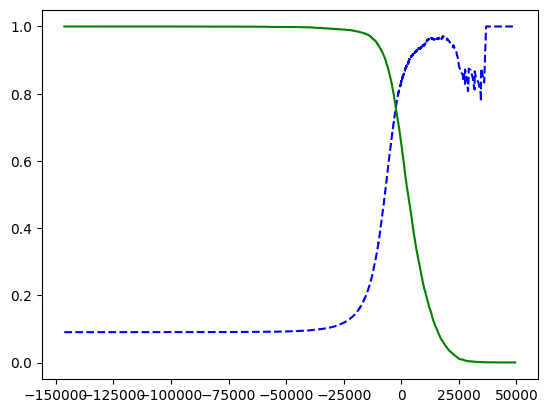

In [20]:
from sklearn.metrics import precision_recall_curve


precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precision_values, recall_values, threshold_values):
    plt.plot(threshold_values, precision_values[:-1], 'b--', label='Precision')
    plt.plot(threshold_values, recall_values[:-1], 'g-', label='Recall')
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

精度并不是随阈值越来越高的：当阈值到达一定程度有点数据可能会被划分到相反的分类去。

In [21]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

threshold_90_precision

3370.0194991439566

In [22]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9000345901072293, 0.4799852425751706)

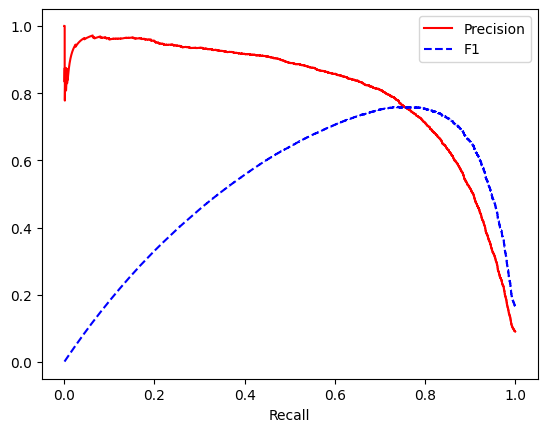

In [23]:

plt.plot(recalls, precisions, 'r', label='Precision')

f1_scores = 2 * recalls * precisions / (recalls + precisions)

plt.plot(recalls, f1_scores, 'b--', label='F1')
plt.xlabel('Recall')

plt.legend()

## 3.5 ROC 曲线

真阳率 / 假阳率


Text(0, 0.5, 'TPR')

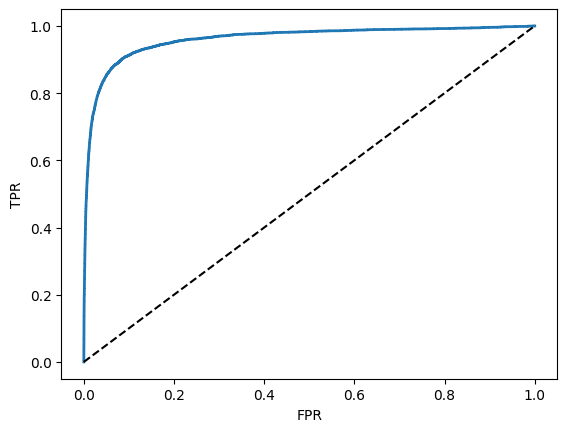

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')

虚线表示纯随机分类的 ROC 曲线，优秀的分类器应该离该曲线越远越好。

可以使用曲线下面积（AUC）来区分分类器的好坏：最好的 ROC AUC = 1，纯随机的 AUC = 0.5。

In [25]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
# predict_proba 
y_prob_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

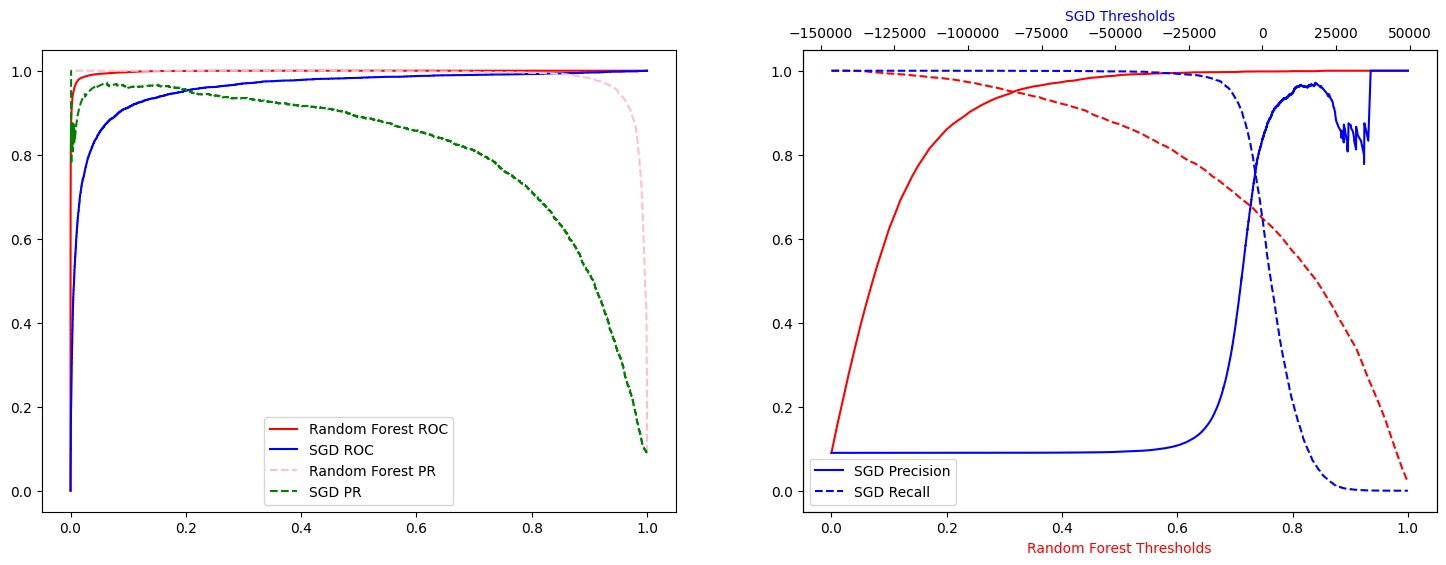

In [27]:
y_scores_forest = y_prob_forest[:, 1]

fpr_forest, tpr_forest, _ = roc_curve(y_train_5, y_scores_forest)
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

_, axes = plt.subplots(1, 2, figsize=(18, 6)) # type: plt.Figure, plt.Axes

ax = axes[0]

ax.plot(fpr_forest, tpr_forest, 'r-', label='Random Forest ROC')
ax.plot(fpr, tpr, 'b-', label='SGD ROC')

ax.plot(recalls_forest, precisions_forest, 'pink', linestyle='--', label='Random Forest PR')
ax.plot(recalls, precisions, 'g', linestyle='--', label='SGD PR')


z_ax = axes[1] # type: plt.Axes
z_ax.plot(thresholds_forest, precisions_forest[:-1], 'r-', label='Random Forest Precision')
z_ax.plot(thresholds_forest, recalls_forest[:-1], 'r--', label='Random Forest Recall')
z_ax.set_xlabel('Random Forest Thresholds', color='r')

n_ax = axes[1].twiny() # type: plt.Axes
n_ax.plot(thresholds, precisions[:-1], 'b-', label='SGD Precision')
n_ax.plot(thresholds, recalls[:-1], 'b--', label='SGD Recall')
n_ax.set_xlabel('SGD Thresholds', color='b')

n_ax.legend()
ax.legend()

# 4. 多类分类器

In [28]:
from sklearn.svm import SVC
from utils.joblib_wrapper import joblib_wrapper

svc_save_path = './models/svc.pkl'


@joblib_wrapper(svc_save_path)
def train_svc() -> SVC:
    svc_model = SVC(random_state=42)
    svc_model.fit(X_train, y_train)
    return svc_model

svc = train_svc() # type: SVC

train_svc发现位于./models/svc.pkl的模型


In [29]:
svc.predict([some_digit])

array([5], dtype=uint8)

In [30]:
some_digit_scores = svc.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [31]:
np.argmax(some_digit_scores)

5

In [32]:
svc.classes_[5]

5